In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.pipeline import Pipeline
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model 
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
  
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
df = pd.read_excel('DFI -Ticketing.xlsx', sheet_name=None)

df = pd.DataFrame(df['Export - Tickets'])

In [3]:
df.head()

ID           Structure  ...     Category Sub-Category
0  55019  NUTRITION ET SANTE  ...  Supervision          NaN
1  55020  POCLAIN HYDRAULICS  ...          NaN          NaN
2  55021             RATPDEV  ...          NaN          NaN
3  55023                D-FI  ...          NaN          NaN
4  55024  POCLAIN HYDRAULICS  ...          NaN          NaN

[5 rows x 29 columns]

In [4]:
df.Type.unique()

array(['Incidents', 'Demandes', 'Changements'], dtype=object)

In [5]:
len_types= [len(df.loc[df['Type']==i])  for i in df.Type.unique()]

weight_for_0 = (1 / len_types[0])*(sum(len_types))/2.0 
weight_for_1 = (1 / len_types[1])*(sum(len_types))/2.0
weight_for_2 = (1 / len_types[2])*(sum(len_types))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))


Weight for class 0: 0.91
Weight for class 1: 1.12
Weight for class 2: 216.16


In [6]:
df.columns

Index(['ID', 'Structure', 'Team', 'Operator', 'Type', 'Status', 'Ticket Title',
       'Incident-Subject', 'Ticket-Description', 'Number of Changes', 'Author',
       'Site', 'Creation-date', 'update-date', 'Validation Time',
       'Treatment Date', 'Delay', 'Action-Time', 'Wait Time', 'Achievement%',
       'Charge réelle', 'Charge estimée', 'SLA', 'Priority', 'Application',
       'Environment', 'ServerName', 'Category', 'Sub-Category'],
      dtype='object')

In [7]:
df = df.dropna(subset=['Ticket-Description','Incident-Subject','Ticket Title','Team','Structure','Number of Changes'])
df.shape

(89018, 29)

In [8]:
not_text_data = df[['Team','Structure','Number of Changes']]
not_text_data.head()

Team           Structure  Number of Changes
0           PILOTAGE  NUTRITION ET SANTE                  2
1           PILOTAGE  POCLAIN HYDRAULICS                  4
2           PILOTAGE             RATPDEV                  3
3  SUPPORT BT NETAPP                D-FI                  2
4           PILOTAGE  POCLAIN HYDRAULICS                  2

In [9]:
not_text_data = pd.get_dummies(not_text_data)

not_text_data.head()

Number of Changes  ...  Structure_ZODIAC MILPRO
0                  2  ...                        0
1                  4  ...                        0
2                  3  ...                        0
3                  2  ...                        0
4                  2  ...                        0

[5 rows x 132 columns]

In [10]:
vocab_size = 10000
embedding_dim = 32
max_length = 2000
trunc_type = 'post'
#padding_type = # YOUR CODE HERE
oov_tok = 'nulll'
training_portion = .8
train_size = int(training_portion*df.shape[0])

In [11]:
not_text_data = not_text_data.values
train_not_text_data = not_text_data[:train_size]
validation_not_text_data =  not_text_data[train_size:]

scaler = MinMaxScaler(feature_range=(0 , 1))
scaler.fit(train_not_text_data)

train_not_text_data = scaler.transform(train_not_text_data)
validation_not_text_data = scaler.transform(validation_not_text_data)

print(len(train_not_text_data))
print(len(validation_not_text_data))

not_text_data.shape

71214
17804


(89018, 132)

In [12]:
stop_words = stopwords.words('french')
print(stop_words)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [13]:
 data= (df['Ticket Title']+df['Incident-Subject']+df['Ticket-Description']).values

 # removing stop words
 text_data=[]

for sentence in data:
    for word in stop_words:
        token = " " + word + " "
        sentence = sentence.replace(token, " ")
        sentence = sentence.replace("  ", " ")
    text_data.append(sentence)


In [14]:

train_text_data = text_data[:train_size]

validation_text_data= text_data[train_size:]

print(train_size)
print(len(train_text_data))
print(len(validation_text_data))


71214
71214
17804


In [15]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text_data)
word_index = tokenizer.word_index

train_text_data = tokenizer.texts_to_sequences(train_text_data)
train_text_data = pad_sequences(train_text_data,maxlen=max_length)




In [16]:

validation_text_data =tokenizer.texts_to_sequences(validation_text_data)
validation_text_data =pad_sequences(validation_text_data,maxlen=max_length)



In [17]:
lables = df['Type']
lables = pd.get_dummies(lables)
lables = lables.values
train_lables = lables[:train_size]
validation_lables =  lables[train_size:]


In [18]:
train_not_text_data = np.reshape(train_not_text_data,(-1,train_not_text_data.shape[1],1))
validation_not_text_data = np.reshape(validation_not_text_data,(-1,validation_not_text_data.shape[1],1))

#train_text_data = np.reshape(train_text_data,(-1,train_text_data.shape[1],1))
#validation_text_data = np.reshape(validation_text_data,(-1,validation_text_data.shape[1],1))

In [19]:
def CNN_LSTM_Model():
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)
    
    model_CNN = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        
        tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[train_not_text_data.shape[1],1]),

        tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu")

         

    ])

    model_LSTM = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",activation="relu"),#,input_shape=[train_text_data.shape[1],1]),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu"),#,input_shape=[train_text_data.shape[1],1]),

       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        #tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="same",activation="relu")

    ])

    Merged = Add()([model_CNN.output,model_LSTM.output])
    #concat = concatenate([model_CNN.output, model_LSTM.output], name='Concatenate')

    Merged = Flatten()(Merged)    
    Merged = Dense(120, activation='relu')(Merged)
    Merged = Dense(60, activation='relu')(Merged)
    Merged = Dense(30, activation='relu')(Merged)

    #mergedOut = Dense(128, activation='relu')(mergedOut)

    # output layer
    Merged = Dense(3 ,activation='softmax')(Merged)
    Merged_CNN_LSTM = Model([model_CNN.input,model_LSTM.input], Merged)

    #sgd = optimizers.SGD(lr=0.1e-8,momentum=0.9)

    Merged_CNN_LSTM.compile(loss='categorical_crossentropy',  optimizer='adam',metrics = 'accuracy')
    
    return Merged_CNN_LSTM

In [20]:
checkpoint_filepath = 'best_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

In [21]:
Merged_CNN_LSTM= CNN_LSTM_Model()
history = Merged_CNN_LSTM.fit([train_not_text_data,train_text_data],train_lables,epochs=5,verbose=1,callbacks=[model_checkpoint_callback],validation_data=([validation_not_text_data,validation_text_data],validation_lables),batch_size=32,shuffle=True)


Epoch 1/5
2226/2226 [==============================] - 561s 247ms/step - loss: 0.2883 - accuracy: 0.8750 - val_loss: 0.2794 - val_accuracy: 0.8999

Epoch 00001: val_loss improved from inf to 0.27936, saving model to best_model
Epoch 2/5
2226/2226 [==============================] - 545s 245ms/step - loss: 0.1547 - accuracy: 0.9437 - val_loss: 0.3517 - val_accuracy: 0.9034

Epoch 00002: val_loss did not improve from 0.27936
Epoch 3/5
2226/2226 [==============================] - 538s 242ms/step - loss: 0.1294 - accuracy: 0.9540 - val_loss: 0.3623 - val_accuracy: 0.8363

Epoch 00003: val_loss did not improve from 0.27936
Epoch 4/5
2226/2226 [==============================] - 528s 237ms/step - loss: 0.1094 - accuracy: 0.9618 - val_loss: 0.4869 - val_accuracy: 0.7971

Epoch 00004: val_loss did not improve from 0.27936
Epoch 5/5
2226/2226 [==============================] - 525s 236ms/step - loss: 0.0927 - accuracy: 0.9685 - val_loss: 0.3485 - val_accuracy: 0.8771

Epoch 00005: val_loss did no

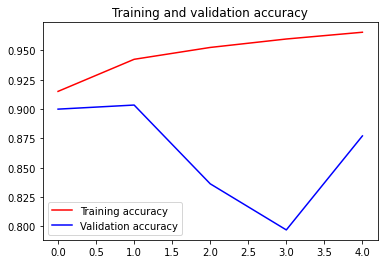

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

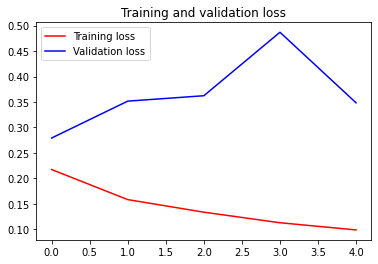

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()